<a href="https://colab.research.google.com/github/carbotton/ML_Notebooks/blob/main/breast_cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ---------------------------------------------------------------
# Ejemplo práctico de clasificación supervisada:
# Breast Cancer Wisconsin (Scikit-Learn)
# ---------------------------------------------------------------

#El objetivo es clasificar tumores mamarios como benignos o malignos a partir de
#un conjunto de datos (Breast Cancer Wisconsin), que contiene 569 muestras y 30
#atributos numéricos extraídos de imágenes (p. ej., “radius_mean”, “texture_mean”, etc.),
#junto con una etiqueta binaria (0 = maligno, 1 = benigno). Este es un problema clásico
#de clasificación supervisada binaria. La tarea consiste en entrenar un modelo que,
#sobre la base de las características de cada muestra, prediga correctamente su diagnóstico.

# Logistic Regression (Regresión Logística)

Por qué se eligió:

El conjunto Breast Cancer Wisconsin tiende a ser casi linealmente separable en el espacio original tras un escalado apropiado, lo que hace que una frontera lineal sea suficiente para obtener buena precisión inicial.

Regresión Logística es rápida de entrenar en un dataset de tamaño moderado (569×30) y, con regularización L2, controla de forma sencilla el sobreajuste.

Proporciona coeficientes interpretables que indican la importancia y relación de cada variable con la clase “maligno vs. benigno” (p. ej., coeficiente positivo en “radius_mean” aumenta la probabilidad de malignidad).

# Random Forest Classifier (Ensamble de Árboles de Decisión)

Por qué se eligió:

Captura interacciones no lineales entre atributos sin necesidad de ingeniería compleja de características: cada árbol puede aprender combinaciones de condiciones (p. ej., “si concavity_worst > x y smoothness_mean < y”).

Es robusto ante outliers y variables irrelevantes, dado que cada árbol usa un subconjunto aleatorio de características y muestras (bootstrap + submuestreo).

Permite extraer importancia de características (feature_importances_) para entender qué atributos son más determinantes.

In [2]:
# 1. Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)

# 2. Cargar el dataset integrado en Scikit-Lean
url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/"
    "breast-cancer-wisconsin/wdbc.data"
)

# Definimos los nombres de las columnas según wdbc.names
columnas = [
    "id",                # Columna 1: ID number
    "diagnosis",         # Columna 2: M = maligno, B = benigno
    # Las siguientes 30 corresponden a los atributos extraídos de imágenes:
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean",
    "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se",
    "compactness_se", "concavity_se", "concave_points_se", "symmetry_se",
    "fractal_dimension_se",
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst",
    "smoothness_worst", "compactness_worst", "concavity_worst",
    "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
]

# Leer directamente desde la URL
df = pd.read_csv(url, header=None, names=columnas)

# Convertir diagnostico en valores numericos: M->0, B->1
df["diagnosis_binary"] = df["diagnosis"].map({"M": 0, "B": 1})

X = df.loc[:, columnas[2:]]   # columnas[2:] arranca en "radius_mean" hasta "fractal_dimension_worst"
y = df["diagnosis_binary"].values # etiquetas binarias

# Mostrar dimensiones y primeras filas para inspección
print("X.shape:", X.shape)  # Esperamos (569, 30)
print("y.shape:", y.shape)  # Esperamos (569,)
print("Ejemplos de y:", np.unique(y))  # Debe dar [0, 1]

X.shape: (569, 30)
y.shape: (569,)
Ejemplos de y: [0 1]


In [3]:
# 3. División en entrenamiento (80%) y prueba (20%), con estratificación de clases

# Al hacer la division en train/test puede quedar desbalanceada la cantidad de ejemplos en cada uno,
# por ejemplo, si hay 90 muestras de benigno y 10 de maligno, al hacer la division aleatoria el
# conjunto de prueba podria no reflejar esa proporcion.
# Al estratificar las clases se garantiza que la proporcion de cada etiqueta en el conjunto de train
# y test coincida o sea aproximadamente igual a la proporcion del dataset original completo.
# stratify=y : toma distribucion de clases en y (ej: 63% benigno, 37% maligno)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nConjunto de entrenamiento:", X_train.shape,
      "Conjunto de prueba:", X_test.shape)

# 4. Feature scaling mediante StandardScaler

# El escalado se usa mas que nada en algoritmos de ML que dependen de distancias.
# Si una variable va de 0 a 1000 y otra entre 0 y 1, el gradiente podria avanzar mas rapido en la
# direccion de la variable grande, dificultando la convergencia.
# Con el escalado vamos a homogeneizar la varianza de cada variable para que sean comparables.
# Metodos comunes: Standarization (restar la medida y dividir entre desviacion estandar),
# Min-Max Scaling (reescalar a un rango fijo, por ejemplo [0,1])
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Ajusta y transforma en train: calcula media y desviacion estandar, ajusta internamente
X_test_scaled = scaler.transform(X_test)        # Usa la misma media y desviacion calculadas en fit_transform para mantener escala

# 5. Entrenamiento de Regresión Logística con búsqueda de hiperparámetros (GridSearchCV) (CV = cross validation)
#    - Penalty: L2 (parametro que agregamos en la funcion de perdida para decidir si permitimos sobreajuste o no. Se busca valor optimo.)
#    - Hiperparámetro C (inverso de regularización)

# Tuning the hyper-parameters of an estimator: (C) https://scikit-learn.org/stable/modules/grid_search.html
# L2 es por la norma L2
# GridSearchCV es una herramienta de Scikit-Learn que permite explorar de manera sistemática combinaciones
# de valores de hiperparámetros y seleccionar la que arroje mejor desempeño según una métrica dada.
param_grid_lr = {"C": [0.01, 0.1, 1, 10, 100]}  # posibles valores a probar
lr_base = LogisticRegression(
    penalty="l2",
    solver="liblinear",      # Bueno para datasets pequeños y L2. Algoritmo interno que optimiza funcion de perdida. Buena convergencia para pocas muestras y/o pocas features
    random_state=42,         # Fija seed para generadores de numeros aleatorios internos que usa el solver. Asegura reproducibilidad.
    max_iter=1000            # Numero maximo de iteraciones que permite el solver antes de detenerse si aun no ha convergido.
)

grid_lr = GridSearchCV(
    estimator=lr_base,
    param_grid=param_grid_lr,
    scoring="accuracy",
    cv=5,                    # Cross validation de 5 folds. El training set se divide en 5 subconjuntos aprox. de igual tamaño. Para cada C, el modelo se entrena 5 veces (4 folds para entrenar, 1 para validation), rotando que fold se usa como validation en cada iteracion. Al final, se promedian las metricas para obtener medida del desempeño.
    n_jobs=-1                # -1: Usar todos los nucleos de CPU disponibles. 1: tareas se ejecutan secuencialmente.
)
grid_lr.fit(X_train_scaled, y_train)

print("\nMejores hiperparámetros (Logistic Regression):", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_


Conjunto de entrenamiento: (455, 30) Conjunto de prueba: (114, 30)

Mejores hiperparámetros (Logistic Regression): {'C': 1}


Precisión (Logistic Regression) en test: 0.9825

Reporte de clasificación (Logistic Regression):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Matriz de confusión (Logistic Regression):
 [[41  1]
 [ 1 71]]


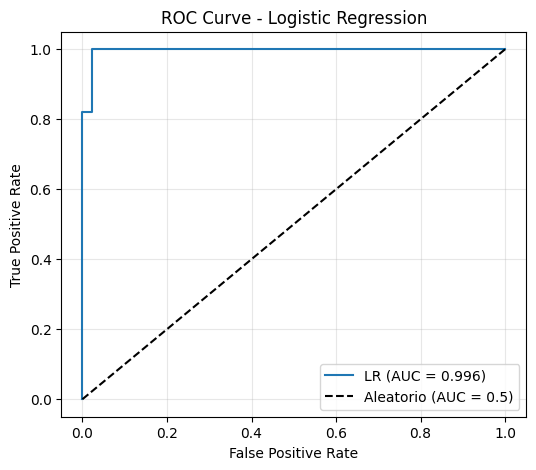

In [6]:
# 6. Evaluación en conjunto de prueba (Logistic Regression)
y_pred_lr = best_lr.predict(X_test_scaled)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Precisión (Logistic Regression) en test: {acc_lr:.4f}")

print("\nReporte de clasificación (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Matriz de confusión (Logistic Regression):\n", cm_lr)

# Curva ROC y cálculo de AUC
y_prob_lr = best_lr.predict_proba(X_test_scaled)[:, 1]  # Prob. clase “benign”
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC = {auc_lr:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Aleatorio (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


Mejores hiperparámetros (Random Forest): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Precisión (Random Forest) en test: 0.9561

Reporte de clasificación (Random Forest):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Matriz de confusión (Random Forest):
 [[39  3]
 [ 2 70]]


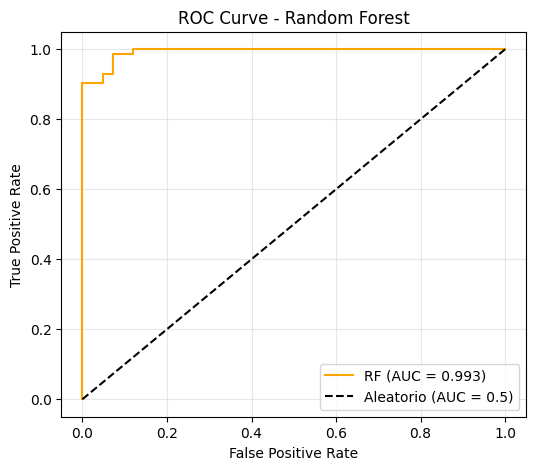


Top 10 características más importantes (Random Forest):
1. perimeter_worst: 0.1331
2. area_worst: 0.1281
3. concave_points_worst: 0.1081
4. concave_points_mean: 0.0944
5. radius_worst: 0.0906
6. radius_mean: 0.0587
7. perimeter_mean: 0.0552
8. area_mean: 0.0499
9. concavity_mean: 0.0462
10. concavity_worst: 0.0354


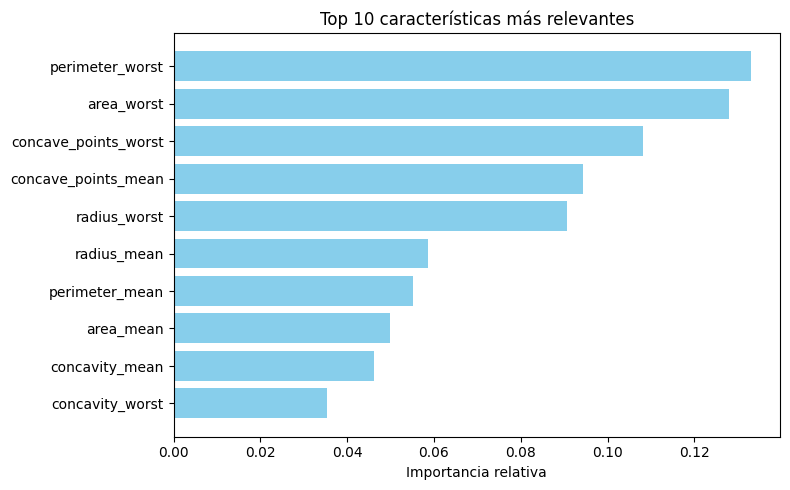

In [9]:
# 7. Entrenamiento de Random Forest con GridSearchCV
#    - n_estimators: número de árboles
#    - max_depth: profundidad máxima de cada árbol
#    - min_samples_split: min. muestras para dividir nodo
param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5]
}
rf_base = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)  # Nota: RandomForest no requiere escalado estricto

print("\nMejores hiperparámetros (Random Forest):", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

# 8. Evaluación en test (Random Forest)
y_pred_rf = best_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Precisión (Random Forest) en test: {acc_rf:.4f}")

print("\nReporte de clasificación (Random Forest):")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Matriz de confusión (Random Forest):\n", cm_rf)

# Curva ROC y AUC (Random Forest)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC = {auc_rf:.3f})", color="orange")
plt.plot([0, 1], [0, 1], "k--", label="Aleatorio (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# 9. Importancia de características (Random Forest)
importances = best_rf.feature_importances_          # Array de largo 30
indices = np.argsort(importances)[::-1]             # Indices ordenados de mayor a menor

feature_names = X.columns                           # Index(['radius_mean', 'texture_mean', ...], dtype='object')

print("\nTop 10 características más importantes (Random Forest):\n")
for i in range(10):
    nombre = feature_names[indices[i]]
    valor = importances[indices[i]]
    print(f"{i+1}. {nombre}: {valor:.4f}")

# Grafico de barras horizontal con las 10 características principales
plt.figure(figsize=(8, 5))
plt.barh(
    np.arange(10)[::-1],             # Posiciones verticales (de abajo hacia arriba)
    importances[indices][:10],       # Valores de importancia (solo top 10)
    align="center",
    color="skyblue"
)
plt.yticks(
    np.arange(10)[::-1],             # Eje y desde 9→0
    feature_names[indices][:10]      # Etiquetas: nombres de las 10 columnas más importantes
)
plt.xlabel("Importancia relativa")
plt.title("Top 10 características más relevantes")
plt.tight_layout()
plt.show()
